In [45]:
# Source: https://www.kaggle.com/code/arunmohan003/feature-selection-tutorial/notebook
#importing ibraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc,roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV

In [46]:
## train test file path
data = './WA_Fn-UseC_-Telco-Customer-Churn.csv.xls'

df = pd.read_csv(data)
print(df.shape)
df.head(3)

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [47]:
df = df.drop(columns=['customerID'])
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: -1 if x == ' ' else float(x))
df['TotalCharges'] = df['TotalCharges'].replace(-1,df['TotalCharges'].mean())


num_cols = ['TotalCharges','MonthlyCharges','tenure']
for col in num_cols:
    df[col] = df[col].astype(np.float32)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   float32
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


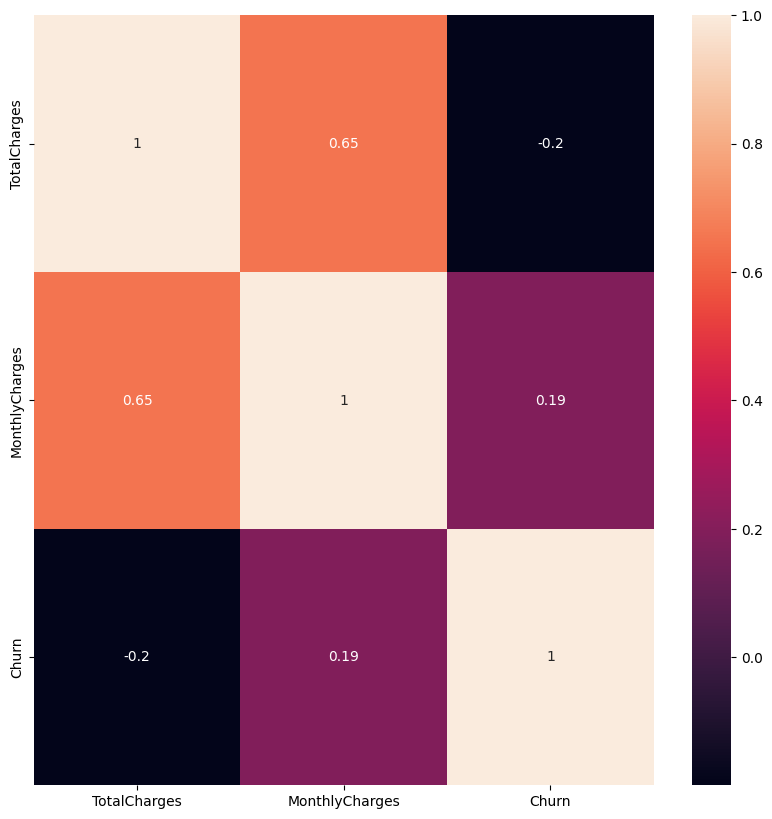

In [50]:
# NOTE: restart kernel every time this cell is rerun because the df gets overwritten
churn = []
for item in df.Churn:
    if item == 'No':
        churn.append(0) 
    elif item == 'Yes':
        churn.append(1)
df.Churn = churn
df_cor = df[['TotalCharges','MonthlyCharges','Churn']].corr()
plt.figure(figsize=(10,10))
sns.heatmap(df_cor,annot=True)
plt.show()

In [51]:
num_cols = ['TotalCharges','MonthlyCharges','tenure']

for col in df.columns:
    if col not in num_cols:
        df[col] = df[col].map({v:i for i,v in enumerate(df[col].value_counts().index)})

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1.0,1,2,1,0,1,0,0,0,0,0,0,0,29.850000,29.850000,0
1,0,0,0,0,34.0,0,0,1,1,0,1,0,0,0,2,1,1,56.950001,1889.500000,0
2,0,0,0,0,2.0,0,0,1,1,1,0,0,0,0,0,0,1,53.849998,108.150002,1
3,0,0,0,0,45.0,1,2,1,1,0,1,1,0,0,2,1,2,42.299999,1840.750000,0
4,1,0,0,0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,70.699997,151.649994,1


In [52]:

y = df['Churn']
X = df.drop(columns=['Churn'])
print(X.shape,y.shape)
print('-'*50)

#60-20-20 split
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=100,stratify=y,test_size=0.2)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)


(7043, 19) (7043,)
--------------------------------------------------
(5634, 19) (5634,)
(1409, 19) (1409,)


In [53]:

clf = DecisionTreeClassifier()
samplesplits = [5, 10, 100, 500]
maximumdepth = [1, 5, 10, 50, 100, 500, 1000]
parameters = {'min_samples_split':samplesplits ,'max_depth':maximumdepth}

model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(x_train,y_train)
print("Model with best parameters :\n",model.best_params_)

### model
best_est = DecisionTreeClassifier(**model.best_params_)
best_est = best_est.fit(x_train,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(x_test)[:,1])

print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Model with best parameters :
 {'max_depth': 5, 'min_samples_split': 100}
Area under train roc 0.8556884872745667
Area under test roc 0.814637422821566


In [54]:
df.shape

(7043, 20)

In [59]:
from sklearn.feature_selection import SequentialFeatureSelector


model = DecisionTreeClassifier(max_depth=5,min_samples_split=100)
sfs = SequentialFeatureSelector(model,n_features_to_select=17,scoring='roc_auc',direction='forward')
sfs.fit(x_train,y_train)


idxes = sfs.get_support(indices=True)
top_feats = x_train.columns[idxes]
print(f'Selected features are {top_feats}')


### model
best_est = DecisionTreeClassifier(max_depth=5,min_samples_split=100)
best_est = best_est.fit(x_train[top_feats],y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(x_train[top_feats])[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(x_test[top_feats])[:,1])


print(f'Results after reducing features from 20 to 17')
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Selected features are Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')
Results after reducing features from 20 to 17
Area under train roc 0.854135998144738
Area under test roc 0.8163347025239608


We can see that on selecting top 17 features our model perfomance increased from 0.814637422821566 to 0.8163347025239608

In [63]:
from sklearn.feature_selection import SequentialFeatureSelector

model = DecisionTreeClassifier(max_depth=5,min_samples_split=100)
sfs = SequentialFeatureSelector(model,n_features_to_select=1,scoring='roc_auc',direction='backward')
sfs.fit(x_train,y_train)


idxes = sfs.get_support(indices=True)
top_feats = x_train.columns[idxes]
print(f'Selected features are {top_feats}')


### model
best_est = DecisionTreeClassifier(max_depth=5,min_samples_split=100)
best_est = best_est.fit(x_train[top_feats],y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(x_train[top_feats])[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(x_test[top_feats])[:,1])


print(f'Results with reduced features')
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

Selected features are Index(['tenure'], dtype='object')
Results with reduced features
Area under train roc 0.7461907736265123
Area under test roc 0.7342904750833139


In this case also removing features improved the perfomance of the model.

In [64]:
best_est.feature_importances_

array([1.])

In [65]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold




model = DecisionTreeClassifier(max_depth=5,min_samples_split=100)
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='roc_auc')
rfecv.fit(x_train,y_train)


print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 3


In [66]:

print(np.where(rfecv.support_ == True)[0])
top_feats = x_train.columns[np.where(rfecv.support_ == True)[0]]



best_est = DecisionTreeClassifier(max_depth=5,min_samples_split=100)
best_est = best_est.fit(x_train[top_feats],y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(x_train[top_feats])[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(x_test[top_feats])[:,1])


print(f'Results with reduced features')
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

[ 4  7 14]
Results with reduced features
Area under train roc 0.8456237712726888
Area under test roc 0.8283835800459842


We can see that with just 3 features our score improved to 0.8283

Thus we can see that feature selection helps in improving our model perfomance.